# Test and Demonstrate zero_gpu_vram_usage Analysis

This notebook tests and demonstrates the main functions in `src/analysis/zero_gpu_vram_usage.py` for analyzing hybrid workload efficiency and CPU-GPU balance.

In [2]:
# Import required modules
import sys
from pathlib import Path

# Add src to sys.path for module imports
sys.path.append(str(Path.cwd().parent / 'src'))

from analysis import zero_gpu_vram_usage

In [3]:
# Load the jobs DataFrame from DuckDB
df = zero_gpu_vram_usage.load_jobs_dataframe_from_duckdb()
display(df.head())
print(len(df))

Connected to C:\Users\ayush\Desktop\Coding\DS4CG\ds4cg-job-analytics\data\slurm_data_small.db


Connected to C:\Users\ayush\Desktop\Coding\DS4CG\ds4cg-job-analytics\data\slurm_data_small.db


,JobID,ArrayID,JobName,IsArray,Interactive,Preempted,Account,User,Constraints,QOS,...,GPUType,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,requested_vram,allocated_vram,user_jobs,account_jobs
20,28982142,-1,p3,False,non-interactive,False,pi_allan_umass_edu,nazaninjafar_umass_edu,[],gypsum-phd-rtx8000,...,[rtx_8000],0.000000e+00,0.0,1.046647e+09,0.158025,0 days 00:00:01,0,48,5,5
21,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,False,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,...,[a100],8.491159e+10,100.0,9.295657e+10,97.740585,0 days 00:04:43,80,80,5,16
22,29004768,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AT95),False,non-interactive,False,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,...,[l40s],9.625928e+08,100.0,3.691685e+10,16.136250,2 days 06:24:31,23,48,891,891
23,29004931,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AUH4),False,non-interactive,False,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,...,[l40s],4.865393e+08,100.0,3.864463e+10,16.197411,2 days 06:53:21,23,48,891,891
24,29004942,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-F4K5Y4),False,non-interactive,False,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,...,[l40s],9.500099e+08,100.0,2.878319e+10,16.564669,2 days 07:05:05,23,48,891,891


23523


In [10]:
# Run analyze_hybrid_workload_efficiency with modular filters
# Example: Only jobs with 0GB requested, at least 1 GPU, and at least 600s duration
# You can change the arguments to filter for different criteria

df_hybrid = zero_gpu_vram_usage.analyze_hybrid_workload_efficiency(
    df,
    requested_vram_filter=0,  # or a function, e.g., lambda x: x <= 2
    allocated_vram_min=0,
    gpu_mem_usage_min=0,
    gpus_min=1,
    elapsed_seconds_min=0 # all jobs
)
display(df_hybrid.head())
print(f"Hybrid jobs found: {len(df_hybrid)}")

,JobID,ArrayID,JobName,IsArray,Interactive,Preempted,Account,User,Constraints,QOS,...,Elapsed_seconds,gpu_memory_used_gb,vram_efficiency,gpu_hours,waste_ratio,efficiency_category,cpu_memory_gb,cpu_gpu_ratio,duration_hours,duration_category
257,29034466,-1,big_fi_64000,False,non-interactive,False,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,...,10912.0,70.771484,0.884644,12.124444,1.130399,High (60-100%),24.954056,0.352600,3.031111,Medium (1-6h)
258,29034468,-1,big_fr_32000,False,non-interactive,False,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,...,7372.0,70.769531,0.884619,8.191111,1.130430,High (60-100%),79.993118,1.130333,2.047778,Medium (1-6h)
259,29034470,-1,big_fr_64000,False,non-interactive,False,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,...,7780.0,70.771484,0.884644,8.644444,1.130399,High (60-100%),33.820240,0.477879,2.161111,Medium (1-6h)
260,29034471,-1,big_hi_8000,False,non-interactive,False,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,...,6326.0,70.773438,0.884668,7.028889,1.130368,High (60-100%),25.392818,0.358790,1.757222,Medium (1-6h)
261,29034472,-1,big_hi_32000,False,non-interactive,False,pi_miyyer_umass_edu,yekyungkim_umass_edu,['a100-80g'],normal,...,7856.0,70.769531,0.884619,8.728889,1.130430,High (60-100%),24.908321,0.351964,2.182222,Medium (1-6h)


Hybrid jobs found: 3521


In [17]:
# Run evaluate_cpu_gpu_balance
analysis_results = zero_gpu_vram_usage.evaluate_cpu_gpu_balance(df_hybrid)

# Display key summary statistics
print("Total jobs:", analysis_results['total_jobs'])
print("Total GPU hours:", analysis_results['total_gpu_hours'])
print("Average VRAM efficiency:", f"{analysis_results['avg_efficiency']:.2%}")
print("Median VRAM efficiency:", f"{analysis_results['median_efficiency']:.2%}")

# Show recommendations
print("\nRecommendations:")
for rec in analysis_results['recommendations']:
    print("-", rec)
# Display efficiency patterns table
analysis_results['efficiency_patterns']

Total jobs: 3521
Total GPU hours: 13358.905833333332
Average VRAM efficiency: 64.49%
Median VRAM efficiency: 75.71%

Recommendations:
- HIGH PRIORITY: Significant inefficiency detected - user education campaign needed
- MAJOR OVER-ALLOCATION: >25% of jobs have >10x waste ratio - implement allocation limits


,Job_Count,GPU_Hours,Avg_Efficiency,Avg_Waste_Ratio,Avg_Allocated_GB,Avg_Used_GB,Percentage_of_Hours
efficiency_category,,,,,,,
Very Low (<10%),408,5270.978,0.031,44.762,23.775,0.763,39.5
Low (10-30%),208,714.779,0.191,5.891,61.678,11.998,5.4
Medium (30-60%),163,1887.614,0.495,2.096,52.331,26.478,14.1
High (60-100%),2737,5457.514,0.779,1.289,18.575,15.252,40.9


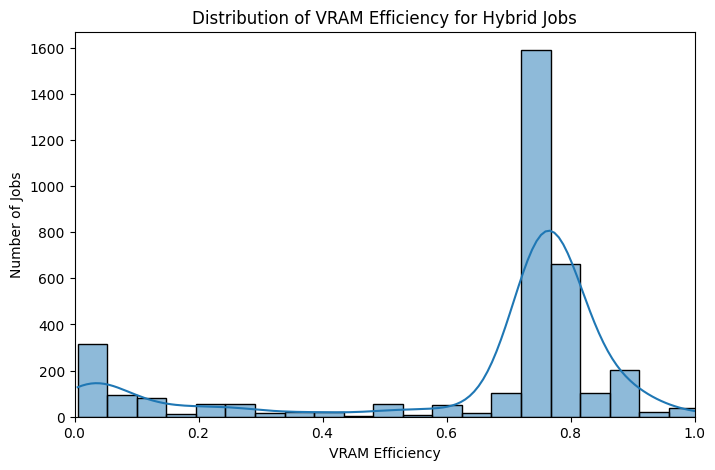

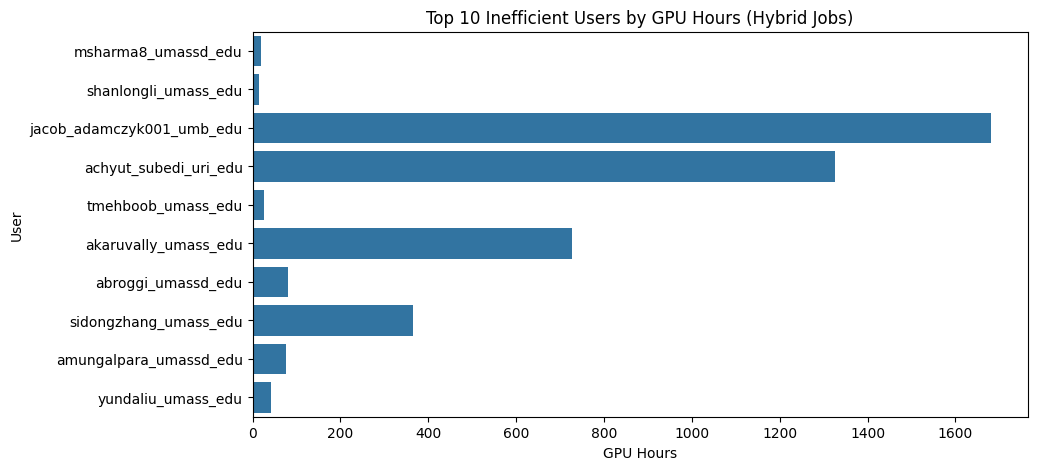

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot VRAM efficiency distribution
plt.figure(figsize=(8, 5))
sns.histplot(df_hybrid['vram_efficiency'].dropna(), bins=30, kde=True)
plt.xlabel('VRAM Efficiency')
plt.ylabel('Number of Jobs')
plt.title('Distribution of VRAM Efficiency for Hybrid Jobs')
plt.xlim(0, 1.0)
plt.show()

# print(analysis_results['top_inefficient_users'].head(5))

# Plot top inefficient users by GPU hours
if 'top_inefficient_users' in analysis_results:
    top_users = analysis_results['top_inefficient_users'].head(10)
    plt.figure(figsize=(10, 5))
    sns.barplot(y=top_users.index, x=top_users['GPU_Hours'], orient='h')
    plt.xlabel('GPU Hours')
    plt.ylabel('User')
    plt.title('Top 10 Inefficient Users by GPU Hours (Hybrid Jobs)')
    plt.show()

In [13]:
# Filter jobs where 0GB VRAM was requested but a GPU was allocated (modular function)
# You can change requested_vram and gpus_min as needed
zero_vram_jobs = zero_gpu_vram_usage.filter_zero_vram_requested_with_gpu_allocated(df, requested_vram=0, gpus_min=1)
display(zero_vram_jobs.head())
print(f"Found {len(zero_vram_jobs)} jobs where 0GB VRAM was requested but a GPU was allocated.")

,JobID,ArrayID,JobName,IsArray,Interactive,Preempted,Account,User,Constraints,QOS,...,GPUMemUsage,GPUComputeUsage,CPUMemUsage,CPUComputeUsage,Queued,requested_vram,allocated_vram,user_jobs,account_jobs,Elapsed_seconds
20,28982142,-1,p3,False,non-interactive,False,pi_allan_umass_edu,nazaninjafar_umass_edu,[],gypsum-phd-rtx8000,...,0.000000e+00,0.0,1.046647e+09,0.158025,0 days 00:00:01,0,48,5,5,345601.0
21,28989215,-1,inference_user_query_review_full.sh,False,non-interactive,False,pi_rrahimi_umass_edu,changzeng_umass_edu,['gpu:a100'],normal,...,8.491159e+10,100.0,9.295657e+10,97.740585,0 days 00:04:43,80,80,5,16,311316.0
22,29004768,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AT95),False,non-interactive,False,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,...,9.625928e+08,100.0,3.691685e+10,16.136250,2 days 06:24:31,23,48,891,891,26602.0
23,29004931,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-A0A1P8AUH4),False,non-interactive,False,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,...,4.865393e+08,100.0,3.864463e+10,16.197411,2 days 06:53:21,23,48,891,891,17465.0
24,29004942,-1,nf-COLABFOLD_COLABFOLD_BATCH_(O64948-F4K5Y4),False,non-interactive,False,pi_bioch642_umass_edu,emccleary_umass_edu,['vram23'],normal,...,9.500099e+08,100.0,2.878319e+10,16.564669,2 days 07:05:05,23,48,891,891,7693.0


Found 9948 jobs where 0GB VRAM was requested but a GPU was allocated.


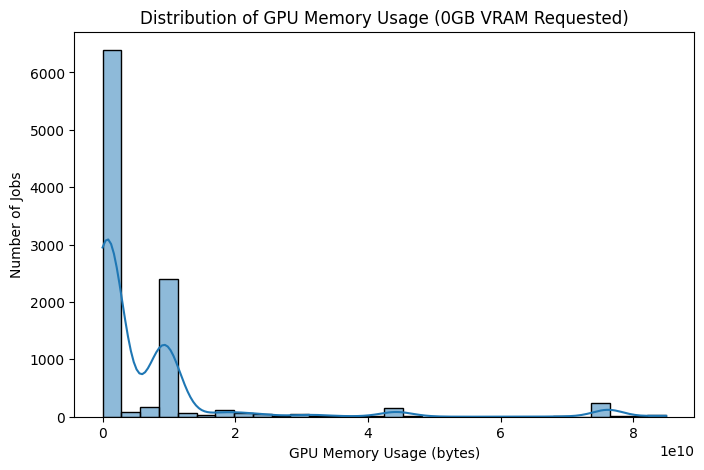

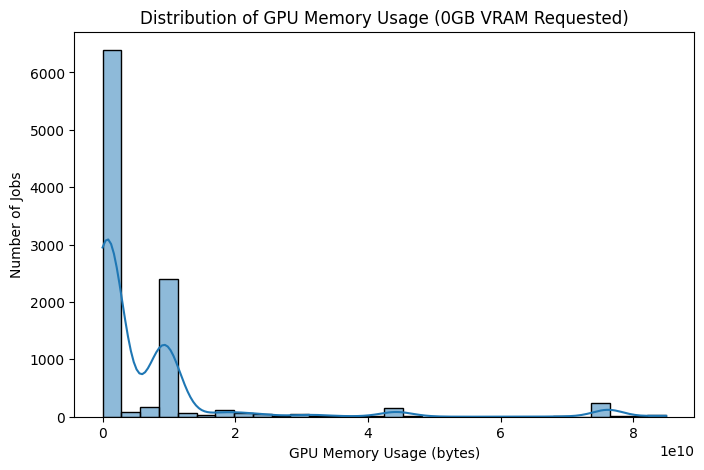

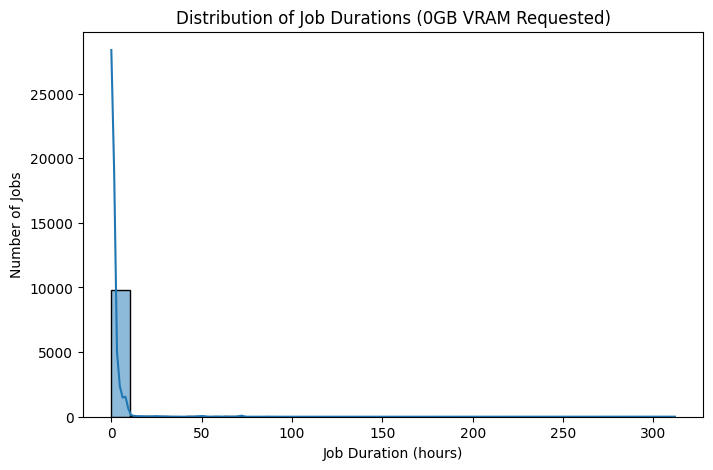

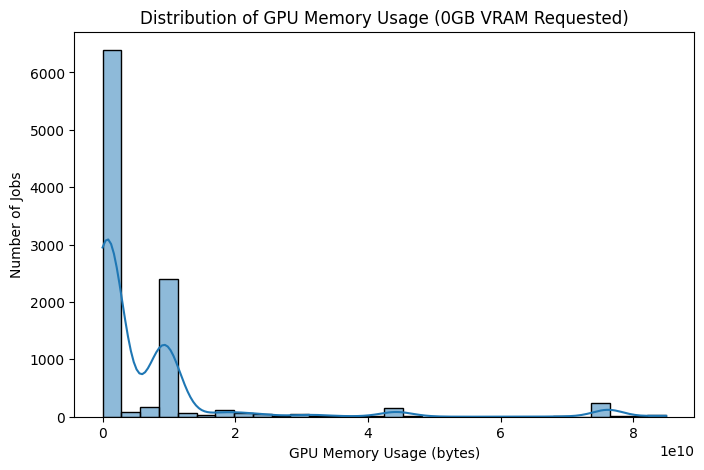

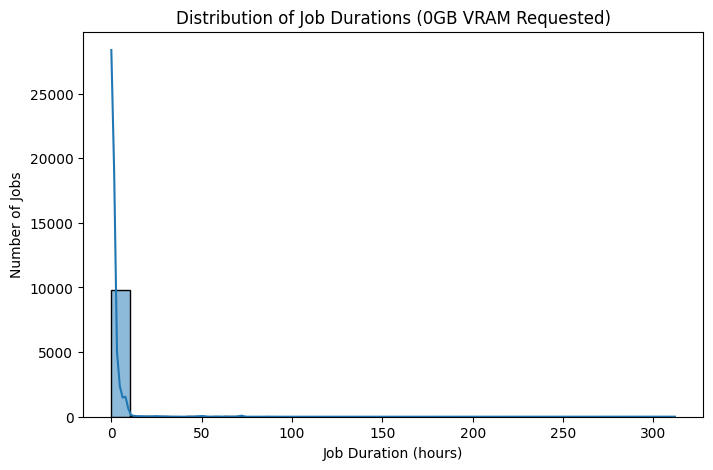

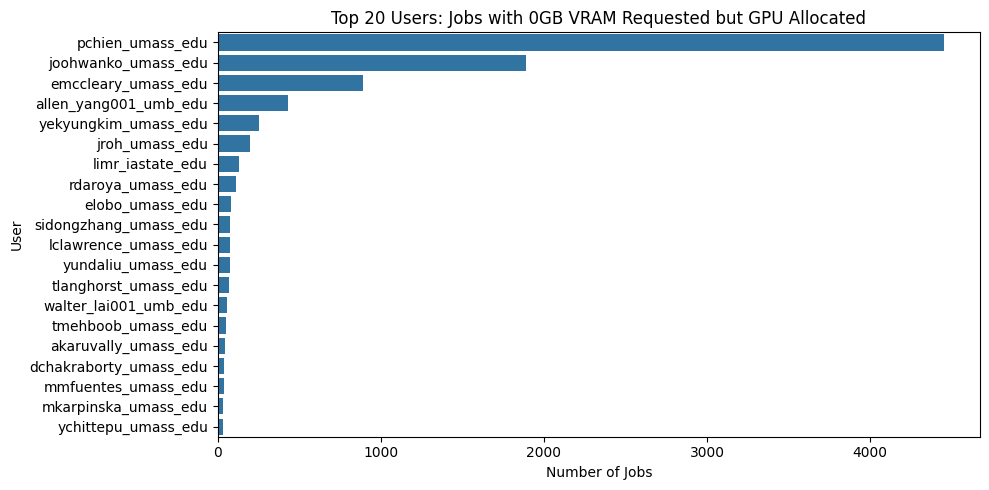

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot statistics for jobs where 0GB VRAM was requested but a GPU was allocated
if not zero_vram_jobs.empty:
    # Plot distribution of GPU memory usage
    plt.figure(figsize=(8, 5))
    sns.histplot(zero_vram_jobs['GPUMemUsage'].dropna(), bins=30, kde=True)
    plt.xlabel('GPU Memory Usage (bytes)')
    plt.ylabel('Number of Jobs')
    plt.title('Distribution of GPU Memory Usage (0GB VRAM Requested)')
    plt.show()

    # Plot distribution of job durations (Elapsed_seconds)
    if 'Elapsed_seconds' in zero_vram_jobs.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(zero_vram_jobs['Elapsed_seconds'].dropna() / 3600, bins=30, kde=True)
        plt.xlabel('Job Duration (hours)')
        plt.ylabel('Number of Jobs')
        plt.title('Distribution of Job Durations (0GB VRAM Requested)')
        plt.show()

    # Plot number of jobs by user
    plt.figure(figsize=(10, 5))
    user_counts = zero_vram_jobs['User'].value_counts().head(20)
    sns.barplot(x=user_counts.values, y=user_counts.index, orient='h')
    plt.xlabel('Number of Jobs')
    plt.ylabel('User')
    plt.title('Top 20 Users: Jobs with 0GB VRAM Requested but GPU Allocated')
    plt.tight_layout()
    plt.show()
else:
    print("No jobs found where 0GB VRAM was requested but a GPU was allocated.")